<a href="https://colab.research.google.com/github/Jack0karev/konoha/blob/master/%D0%9A%D0%B0%D1%80%D0%B5%D0%B2_%D0%92%D0%B0%D1%81%D0%B8%D0%BB%D0%B8%D0%B9_%D0%9C%D0%A1%D0%90_211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part #1
### Download data
* Данные были взяты с сайта kaggle.com (https://www.kaggle.com/harlfoxem/housesalesprediction). По указанной ссылке можно ознакомится с основной задачей поставленной в рамках имеющегося датасета. Этот набор данных содержит цены продажи домов для округа Кинг, включая Сиэтл. В датасет входят дома, проданные в период с мая 2014 года по май 2015 года.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/Colab Notebooks/kc_house_data.csv' kc_house_data.csv

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf


df = pd.read_csv('kc_house_data.csv')
df.head()

Mounted at /content/drive


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Описание переменных
* id: идентикафиционный номер дома
* date: дата покупки дома
* price: цена продажи дома(зависимая переменная)
* bedrooms: количество спальных комнат
* bathrooms: количетсво ванных комнат 
* sqft_living: жилая площадь в квадратных футах
* sqft_lot: площадь земенльного участка в квадратных футах
* floors: количество этажей
* waterfront: дамми переменная отвечающая за наличие побережья рядом с домом: "1" - есть, "0" - отсутсвует
* view: количество просмотров дома
* condition: состояние дома: 1-ужасное, ..., 5-отличное
* grade: оценка дома оценщиками
* sqft_above: площадь дома без учета подвального помещения
* sqft_basement: площадь подвального помещения дома
* yr_built: год постройки дома
* yr_renovated: год реновации дома
* zipcode: zipcode
* lat: широта, на которой находится дом
* long: долгота, на которой находится дом
* sqft_living15: жилая площадь в квадратных футах в 2015 году
* sqft_lot15: площадь земенльного участка в квадратных футах в 2015 году

**Замечание**: для упрощения визуализаций и в целом работы были взяты следующие переменные:
- price (зависимая переменнаяй)
- bedrooms
- sqft_living
- floors
- waterfront
- condition
- yr_built

In [2]:
df = df[['price', 'bedrooms', 'sqft_living', 'floors', 'waterfront', 'condition', 'yr_built']]

# Part #2
## Дескриптивный анализ данных

In [3]:
df.describe().T.style.bar(
    subset=['mean'],
    color='#606ff2').background_gradient(
    subset=['std'], cmap='PuBu').background_gradient(subset=['50%'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
price,21613.000000,540088.141767,367127.196483,75000.000000,321950.000000,450000.000000,645000.000000,7700000.000000
bedrooms,21613.000000,3.370842,0.930062,0.000000,3.000000,3.000000,4.000000,33.000000
sqft_living,21613.000000,2079.899736,918.440897,290.000000,1427.000000,1910.000000,2550.000000,13540.000000
floors,21613.000000,1.494309,0.539989,1.000000,1.000000,1.500000,2.000000,3.500000
waterfront,21613.000000,0.007542,0.086517,0.000000,0.000000,0.000000,0.000000,1.000000
condition,21613.000000,3.409430,0.650743,1.000000,3.000000,3.000000,4.000000,5.000000
yr_built,21613.000000,1971.005136,29.373411,1900.000000,1951.000000,1975.000000,1997.000000,2015.000000


## Выводы по таблице
- Стоит обратить внимание на bedrooms и sqft_living, т.к. данные переменные содержат выбросы, поскольку максимольно значение сильно превышает величину межквартильного размаха, следовательно стоит учесть данные фактор при построении регрессии
- Можно предположить, что непрерывные переменные имеют незначительный скос, потому что в большинстве случае медианное значение отличается от среднего, следовательно данные ассиметричны

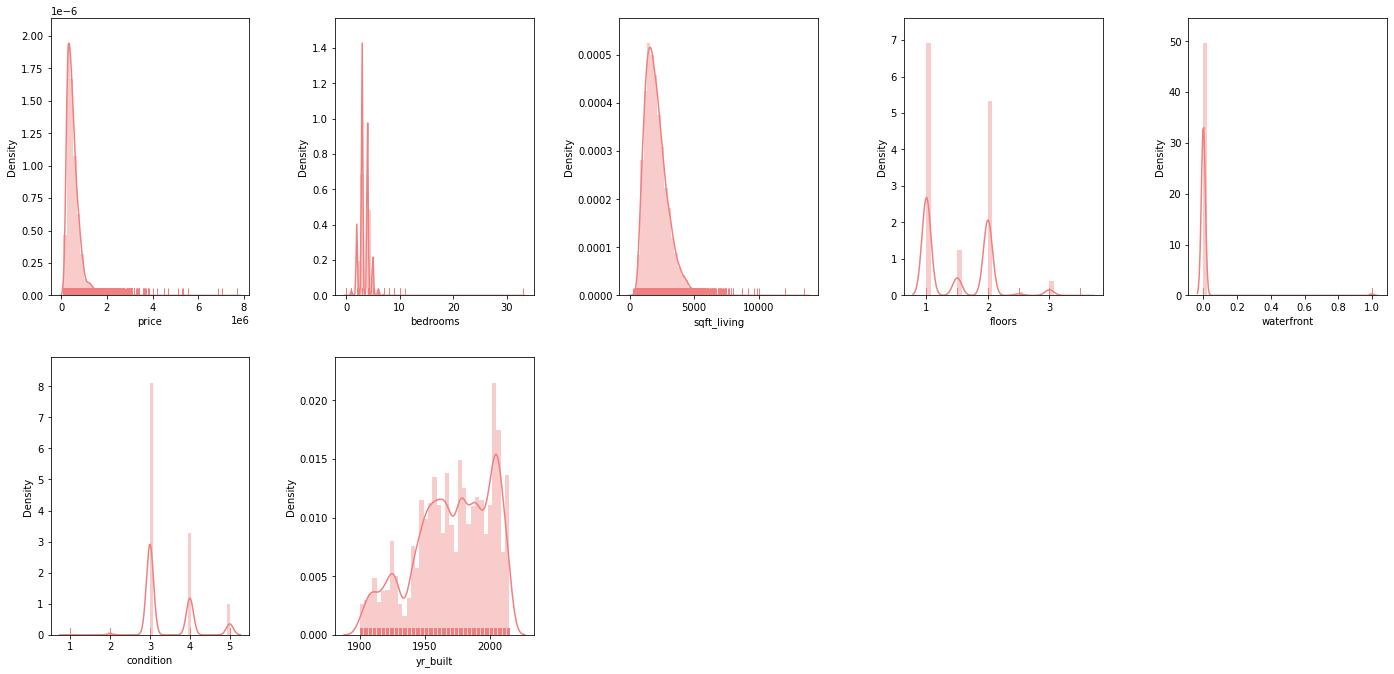

In [4]:
fig = plt.figure(figsize=(20, 10))
for i in range(len(df.columns)):
    fig.add_subplot(np.ceil(len(df.columns)/5), 5, i+1)
    sns.distplot(
        df.iloc[:, i], color="lightcoral", rug=True)
    fig.tight_layout(pad=3.0)

## Выводы по графикам
- Визуально не одна из рассматриваемых переменных не вы глядит как нормальное распределение
- В переменной waterfront отностельно маленькое число наблюдений, где переменная принимает значение "1"
- Вероятней всего стоит воспользоваться логарифмическим преобразовнием для цены и жилой площади, чтобы перейти к более линейной форме данных 

# Part #3
* В данной часте будут рассмотрены две группы цен, первая содержит цены на дома, в которых условия для проживания оцениваются как "средние" (condition = 3), а во второй группе будут содержаться цены на дома, в которых условия проживания оценваются как "отличные" (condition = 5). 
* Предворительно построим boxplot, возможно получится опредеить визуально равенстов дисперсий или нет 

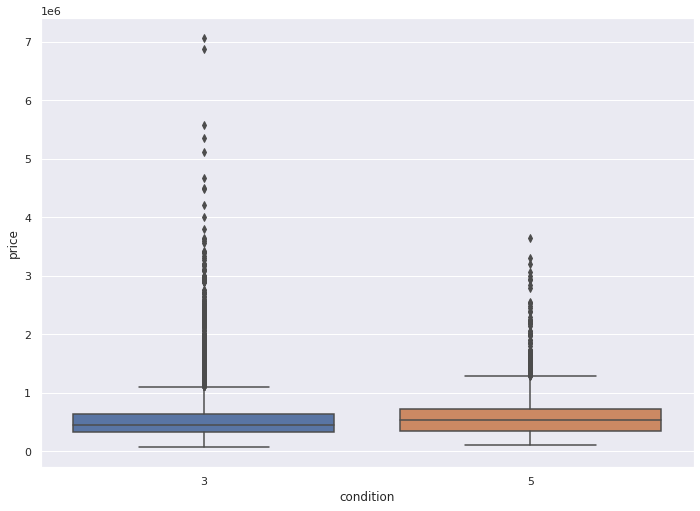

In [5]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="condition", y="price", data=df[df.condition.isin([3,5])])

* Проведем тест Левене на равенство дисперсий. В данном тесте нулевая гипотеза - диспрсии в исследуемых равны, альтернативная утверждает обратное. В данном тесте в качестве центрального значения будет использоваться медиана, т.к. наблюдаемые выборки явно имеют скос.

In [6]:
from scipy.stats import levene
stat, p = levene(df.price[df.condition == 3], df.price[df.condition == 5], center = 'median')
if p > 0.05:
  print(f'Observed statistic: {stat}, p-value = {p}')
  print('The null hypothesis does not reject')
else:
  print(f'Observed statistic: {stat}, p-value = {p}')
  print('The null hypothesis is rejected')

Observed statistic: 36.420407180330564, p-value = 1.62598082881586e-09
The null hypothesis is rejected


* На основе проведенного теста видно, что гипотеза о равенстве дисперсий выборок отвергается, следовательно, для проверки гипотезы о равенстве средних необходимо указать данный факт.

In [7]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(df.price[df.condition == 3], df.price[df.condition == 5], equal_var=False)
if p > 0.05:
  print(f'Observed statistic: {stat}, p-value = {p}')
  print('The null hypothesis does not reject')
else:
  print(f'Observed statistic: {stat}, p-value = {p}')
  print('The null hypothesis is rejected')

Observed statistic: -6.751070234843345, p-value = 1.907385777279934e-11
The null hypothesis is rejected


*  На основе проделанных этапов можно утверждать, что средняя цена для домов, в которых условия для проживания оцениватся как "отличные", отличается от средней цены домов в которых условия для проживания оцениваются как "средние". 
* Далее построим доверительный интервал для среднего и диспрсии цены продажи лома (без каких-либо условий)

In [8]:
import statsmodels.stats.api as sms
left_m, right_m = sms.DescrStatsW(df.price).tconfint_mean(alpha=0.05)

from scipy import stats
alpha = 0.05 
n = df.price.count()
var_hat = df.price.var(ddof=1)
chi_l, chi_u = stats.chi2.ppf([1-alpha/2, alpha/2], df = n-1)
left_v = (n - 1) * var_hat / chi_l  
right_v = (n - 1) * var_hat / chi_u

print(f'Confidence interval for mean: lower bounder - {round(left_m, 2)}, upper bounder - {round(right_m, 2)}')
print(f'Confidence interval for varience: lower bounder - {round(left_v, 2)}, upper bounder - {round(right_v, 2)}')

Confidence interval for mean: lower bounder - 535193.38, upper bounder - 544982.9
Confidence interval for varience: lower bounder - 132276788483.12, upper bounder - 137360178746.42


In [9]:
from scipy.stats import bayes_mvs
mean_bayes, var_bayes, std_bayes = bayes_mvs(df.price, alpha=0.95)
left_m, right_m  = mean_bayes.minmax
left_v, right_v = var_bayes.minmax
print(f'Credible interval for mean: lower bounder - {round(left_m, 2)}, upper bounder - {round(right_m, 2)}')
print(f'Credible interval for varience: lower bounder - {round(left_v, 2)}, upper bounder - {round(right_v, 2)}')

Credible interval for mean: lower bounder - 535193.77, upper bounder - 544982.51
Credible interval for varience: lower bounder - 132235060790.56, upper bounder - 137317223660.58


* Как можно заметить доверительный интервал и достоверный интервал двольно таки близки по абсолютному значению, то есть в данном случае между ними нет критической разницы, значит можно использовать равноценно данные ДИ для проверки необходимых тестов.

# Part #4

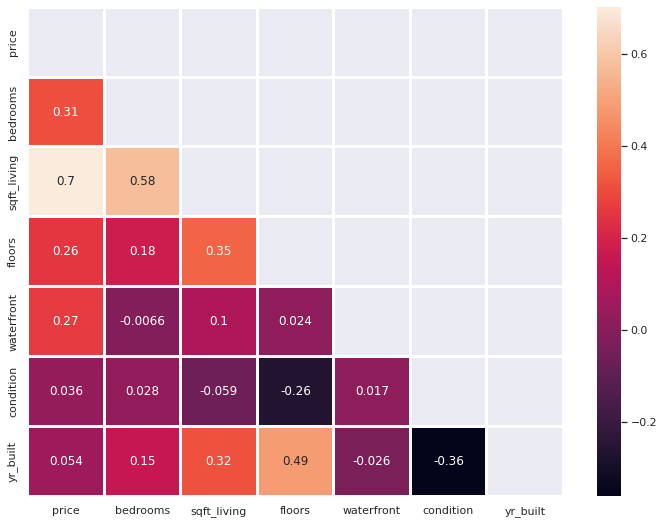

In [10]:
corr_data = df
plt.figure(figsize=(12, 9))
matrix = np.triu(corr_data.corr())
sns.heatmap(corr_data.corr(), annot=True,
            linewidth= 2, mask=matrix, cmap="rocket");

## Выводы по диаграмме корреляций
- наблюдается корреляция между ценой и жилой площадью, что является довольно очевидным фактом, поскольку это является прямым фактом вложенных денег в дом
- кроме того, видно, что существует слабая отрицательная взаимосвязь между годом постройки дома и условиями проживания в нем, что объясняется износом и ухудшением состояния со временем
- жилая площаль коррелирует с количеством спален за счет того, что спальная комната входит в жилую площадь, следовательно чем больше спален, тем больше жилая площадь

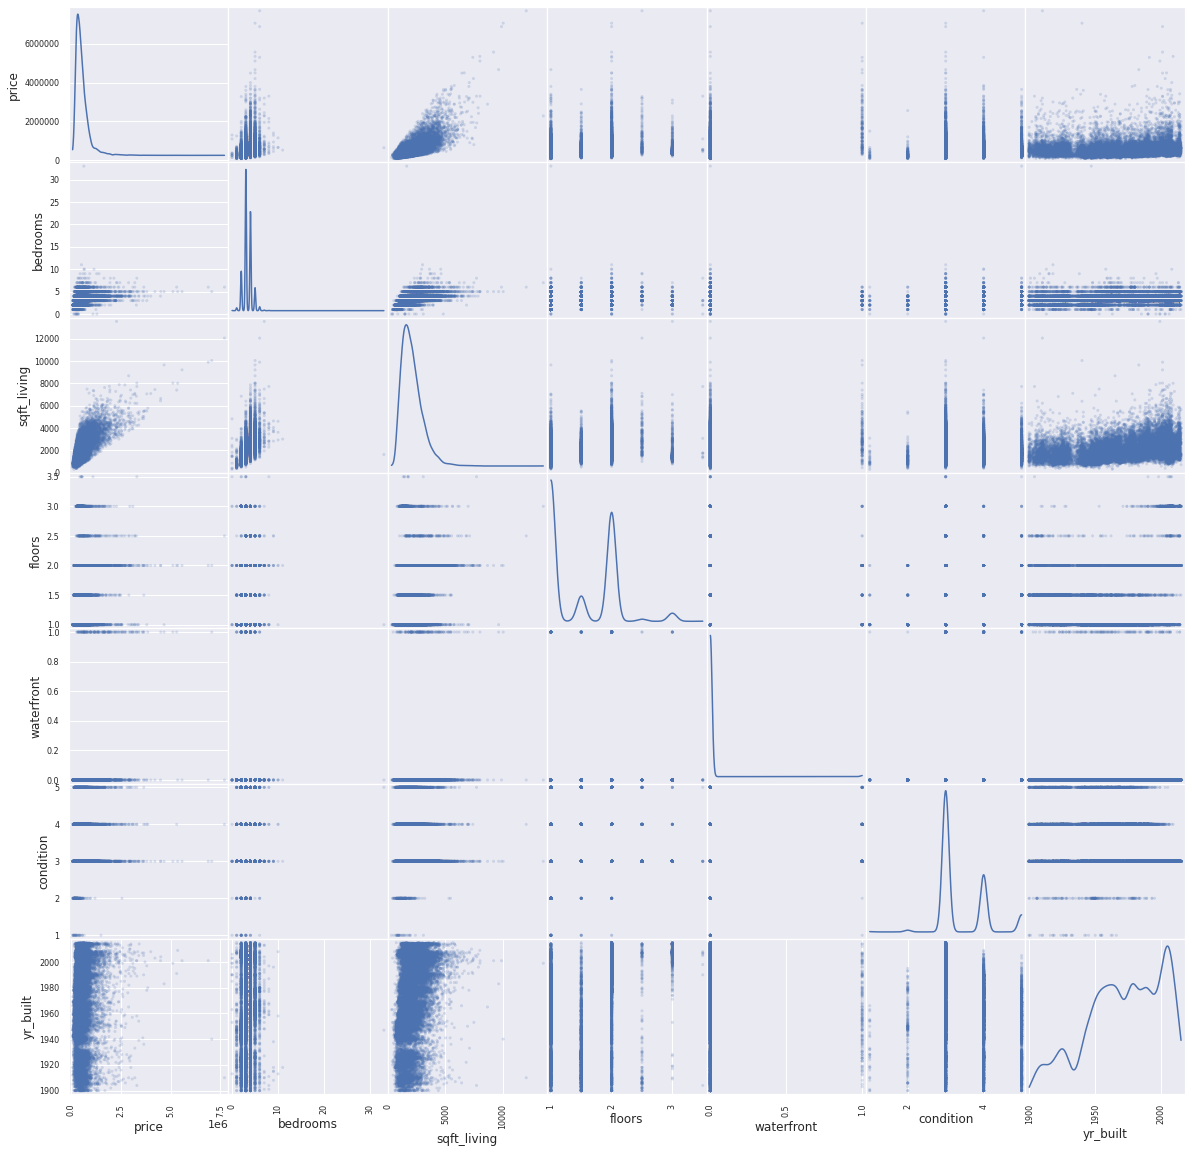

In [11]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20,20), diagonal='kde')
plt.show()

## Выводы по диаграммам рассеяния
- Исходя из представленных, становится очевидным тот факт, что зависимая переменная линейно зависа от жилой площади, а для остальных переменных тяжело сформулировать отднозначное утверждение, поскольку диаграммы рассеяния имеют крайне неочевидные контуры

# Part #5
## Задача регрессии
- Данный датасет изначально был направлен на то, чтобы построить модель, которая могла бы по вводным данным выдавть цену продажи дома соотвествующую рынку

In [30]:
mod = smf.ols(formula='price ~ bedrooms + sqft_living + waterfront + floors + condition + yr_built', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4962.
Date:                Tue, 02 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:51:23   Log-Likelihood:            -2.9824e+05
No. Observations:               21613   AIC:                         5.965e+05
Df Residuals:                   21606   BIC:                         5.966e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.137e+06   1.33e+05     38.642      

In [31]:
print(f'MSE of model: {res.mse_resid}')

MSE of model: 56697206102.202095


# Выводы по модели
- В данном случае значение MSE крайне велико, из-за чего нельзя использовать данную метрику качества модели. Такое значение связано с тем для рынка недвижимости колебание цены в 10000$ является приемлемым, что приводит в высокому значению средне квадратичной ошибки
- Если говорить о коэффициентах детерминации, то их значение говорит о том, что построенная модель способна объяснить приблизительно 57.9%, можно с увереностью сказать, что модель относительно хорошо предсказывает цены на недвижимость
- Говоря о значимости коэффициентов, стоит отметить тот факт, что все коэффициенты являются значимыми, т.к. все доверительные интервалы не содержат нуля, кроме того F-test и t-test-ы подтверждают данный факт
- Высокое абсолютное значение коэффициентов наводит на мысль о том, что стоит использовать модели с регулязацией, но это уже не входит в дз)